In [1]:
"""
Assume a matrix multiplication workload and a two-level hardware.
I'm assuming two loops per rank variable.
The goal is to see how many mappings always result in the exact same cost.

For example, the following two mappings should have the same cost:
```
# Note the following two loops
for m
 for n
  GLB keeps Z
   for m
    for k
     GLB keeps A
      for k
       for n
        GLB keeps B
```
and
```
# Note the following two loops
for n
 for m
  GLB keeps Z
   for m
    for k
     GLB keeps A
      for k
       for n
        GLB keeps B
```
"""

"\nAssume a matrix multiplication workload and a two-level hardware.\nI'm assuming two loops per rank variable.\nThe goal is to see how many mappings always result in the exact same cost.\n\nFor example, the following two mappings should have the same cost:\n```\n# Note the following two loops\nfor m\n for n\n  GLB keeps Z\n   for m\n    for k\n     GLB keeps A\n      for k\n       for n\n        GLB keeps B\n```\nand\n```\n# Note the following two loops\nfor n\n for m\n  GLB keeps Z\n   for m\n    for k\n     GLB keeps A\n      for k\n       for n\n        GLB keeps B\n```\n"

In [2]:
from functools import reduce
from math import factorial
from operator import mul

def num_dataflows(num_loops: list[int]) -> int:
    """Counts number of dataflows."""
    return factorial(sum(num_loops)) // reduce(mul, (factorial(x) for x in num_loops), 1)


print("Number of dataflows: ", num_dataflows([2, 2, 2]))

Number of dataflows:  90


In [31]:
class Loop:
    def __init__(self, rank_var: str):
        self.rank_var = rank_var

    def __repr__(self):
        return f"Loop({self.rank_var})"

    def __lt__(self, other):
        return self.rank_var < other.rank_var

    def __eq__(self, value: "Loop"):
        if isinstance(value, Loop):
            return self.rank_var == value.rank_var
        else:
            return False

    def __hash__(self):
        return hash(self.rank_var)


class Storage:
    def __init__(self, tensor: str):
        self.tensor = tensor

    def __repr__(self):
        return f"Storage(\"{self.tensor}\")"

    def __hash__(self):
        return hash(self.tensor)
    
    def __eq__(self, value: "Storage"):
        if isinstance(value, Storage):
            return self.tensor == value.tensor
        else:
            return False


class Reservation:
    def __init__(self, tensor: str):
        self.tensor = tensor

    def __repr__(self):
        return f"Reservation(\"{self.tensor}\")"
    
    def __hash__(self):
        return hash(self.tensor)
    
    def __eq__(self, value: "Reservation"):
        if isinstance(value, Reservation):
            return self.tensor == value.tensor
        else:
            return False


FIRST_MAPPING = [Loop('n'), Loop('m'), Storage('Z'), Loop('m'), Loop('k'), Storage('A'), Loop('k'), Loop('n'), Storage('B')]

RELEVANCY = {
    Storage('A'): {Loop('m'), Loop('k')},
    Storage('B'): {Loop('n'), Loop('k')},
    Storage('Z'): {Loop('m'), Loop('n')},
}


def generate_canonical_mapping(mapping):
    last_storage = None
    # Relevancy is defined wrt the last storage seen; if none seen, all unlowerable
    collected_lowerable_loops = set()
    collected_unlowerable_loops = set()
    canonical_mapping = []
    for element in mapping:
        if isinstance(element, Storage):
            canonical_mapping.extend(sorted(collected_lowerable_loops))
            if last_storage is not None:
                canonical_mapping.append(Reservation(last_storage.tensor))
            canonical_mapping.extend(sorted(collected_unlowerable_loops))
            canonical_mapping.append(element)
            last_storage = element
            can_lower = True
            collected_lowerable_loops.clear()
            collected_unlowerable_loops.clear()
        elif isinstance(element, Loop):
            if last_storage is None:
                collected_unlowerable_loops.add(element)
            elif element not in RELEVANCY[last_storage]:
                collected_unlowerable_loops.add(element)
                can_lower = False
            elif can_lower:
                collected_lowerable_loops.add(element)
            else:
                collected_unlowerable_loops.add(element)
        else:
            raise RuntimeError("Bug")

    canonical_mapping.extend(sorted(collected_lowerable_loops))
    if last_storage is not None:
        canonical_mapping.append(Reservation(last_storage.tensor))
    canonical_mapping.extend(sorted(collected_unlowerable_loops))

    return tuple(canonical_mapping)

generate_canonical_mapping([Loop('n'), Loop('m'), Storage('Z'), Loop('m'), Loop('k'), Storage('A'), Loop('k'), Loop('n'), Storage('B')])

(Loop(m),
 Loop(n),
 Storage("Z"),
 Loop(m),
 Reservation("Z"),
 Loop(k),
 Storage("A"),
 Loop(k),
 Reservation("A"),
 Loop(n),
 Storage("B"),
 Reservation("B"))

In [33]:
from more_itertools import distinct_permutations

canonical_to_count = {}
for mapping in distinct_permutations(FIRST_MAPPING):
    canonical = generate_canonical_mapping(mapping)
    if canonical not in canonical_to_count:
        canonical_to_count[canonical] = 0
    canonical_to_count[canonical] += 1

In [34]:
print("Number of unique canonical mappings: ", len(canonical_to_count))
print("Number of mappings: ", sum(canonical_to_count.values()))
print("Average mappings per canonical mapping: ", sum(canonical_to_count.values()) // len(canonical_to_count))

Number of unique canonical mappings:  16542
Number of mappings:  45360
Average mappings per canonical mapping:  2


Text(0, 0.5, 'Number of canonical mappings')

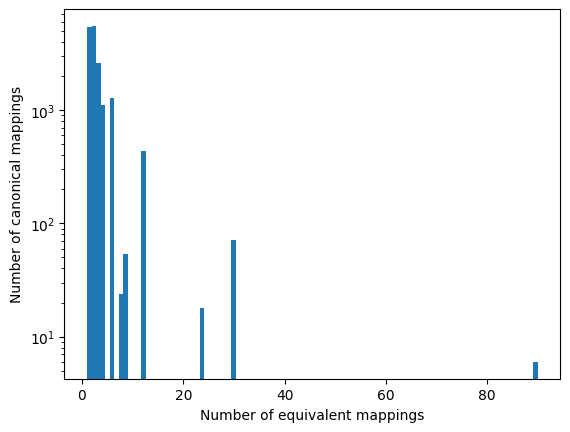

In [35]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.hist(canonical_to_count.values(), bins=100)
ax.set_yscale('log')
ax.set_xlabel('Number of equivalent mappings')
ax.set_ylabel('Number of canonical mappings')

In [36]:
mapping_count = []
canonical_mapping_count = []

import tqdm
from more_itertools import distinct_permutations

for lpf_limit in range(1, 4):
    first_mapping = [Loop('n')]*lpf_limit + [Loop('m')]*lpf_limit  + [Loop('k')]*lpf_limit+ [Storage('Z')] + [Storage('A')] + [Storage('B')]

    canonical_set = set()
    count = 0
    for mapping in tqdm.tqdm(distinct_permutations(first_mapping)):
        canonical = generate_canonical_mapping(mapping)
        canonical_set.add(canonical)
        count += 1

    mapping_count.append(count)
    canonical_mapping_count.append(len(canonical_set))

720it [00:00, 176499.06it/s]
45360it [00:00, 153421.44it/s]
2217600it [00:12, 180100.97it/s]


In [37]:
print(mapping_count)
print(canonical_mapping_count)

[720, 45360, 2217600]
[546, 16542, 105780]


Text(0, 0.5, 'Average mappings per canonical mapping')

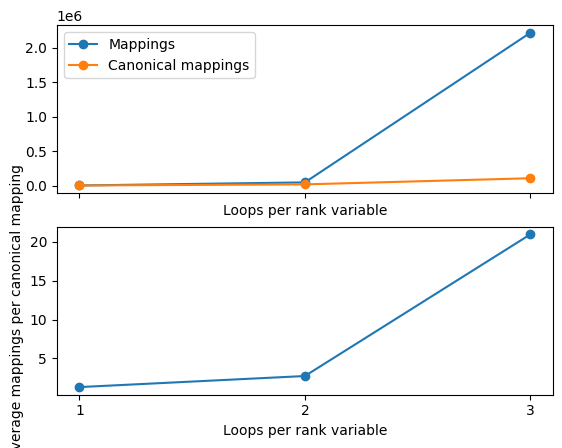

In [50]:
fig, axes = plt.subplots(2, 1, sharex=True)
ax = axes[0]
ax.plot(range(1, len(avg_redundancy)+1), mapping_count, marker='o', label='Mappings')
ax.plot(range(1, len(avg_redundancy)+1), canonical_mapping_count, marker='o', label='Canonical mappings')
ax.set_xticks(range(1, len(avg_redundancy)+1))
ax.set_xlabel('Loops per rank variable')
ax.legend()

ax = axes[1]
avg_redundancy = [m / c for m, c in zip(mapping_count, canonical_mapping_count)]
ax.plot(range(1, len(avg_redundancy)+1), avg_redundancy, marker='o')
ax.set_xticks(range(1, len(avg_redundancy)+1))
ax.set_xlabel('Loops per rank variable')
ax.set_ylabel('Average mappings per canonical mapping')